## Install packages not provided by Google Cloud.

In [8]:
!pip install tensorboard

In [13]:
!sudo apt-get install --assume-yes unar ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unar is already the newest version (1.10.1-2+b4).
ffmpeg is already the newest version (7:4.1.10-0+deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


## Import packages.

In [1]:
import os, glob, shutil
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

In [3]:
import torchvision

In [4]:
from torchvision.models.efficientnet import efficientnet_b3

In [5]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Linear
import math

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Prepare UCF10 dataset by choosing 10 classes.

In [4]:
!wget https://www.crcv.ucf.edu/data/UCF50.rar --no-check-certificate

--2023-06-03 06:11:17--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  75.4MB/s    in 41s     

2023-06-03 06:11:58 (75.5 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [5]:
!unar UCF50.rar

UCF50.rar: RAR
  UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi  (318098 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g01_c02.avi  (289150 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g01_c03.avi  (298846 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g01_c04.avi  (320434 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g01_c05.avi  (281550 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g01_c06.avi  (328052 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g02_c01.avi  (200498 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g02_c02.avi  (172652 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g02_c03.avi  (193658 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g02_c04.avi  (197638 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g03_c01.avi  (225122 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g03_c02.avi  (276488 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g03_c03.avi  (195754 B)... OK.
  UCF50/BaseballPitch/v_BaseballPitch_g03_c04.avi  (209348 B)... OK.
  UCF50/BaseballPit

In [6]:
!rm UCF50.rar

In [7]:
os.makedirs('UCF10')

In [8]:
np.random.seed(0)
for type_dir in np.random.choice(glob.glob('UCF50/*/'), size=10, replace=False):
    shutil.copytree(str(type_dir), 'UCF10/'+str(type_dir).split('/')[-2])

In [9]:
!rm -rf UCF50

In [10]:
for video_file in glob.glob('UCF10/*/*.avi'):
    frame_dir = video_file.replace('.avi', '')
    if not os.path.isdir(frame_dir):
        os.makedirs(frame_dir)
    os.system(f'ffmpeg -i {video_file} {frame_dir}/%04d.png -hide_banner')

Input #0, avi, from 'UCF10/Biking/v_Biking_g17_c01.avi':
  Metadata:
    encoder         : Lavf52.31.1
  Duration: 00:00:05.07, start: 0.000000, bitrate: 604 kb/s
    Stream #0:0: Video: mpeg4 (Simple Profile) (xvid / 0x64697678), yuv420p, 320x240 [SAR 1:1 DAR 4:3], 593 kb/s, 29.97 fps, 29.97 tbr, 29.97 tbn, 29.97 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (mpeg4 (native) -> png (native))
Press [q] to stop, [?] for help
Output #0, image2, to 'UCF10/Biking/v_Biking_g17_c01/%04d.png':
  Metadata:
    encoder         : Lavf58.20.100
    Stream #0:0: Video: png, rgb24, 320x240 [SAR 1:1 DAR 4:3], q=2-31, 200 kb/s, 29.97 fps, 29.97 tbn, 29.97 tbc
    Metadata:
      encoder         : Lavc58.35.100 png
frame=  152 fps=0.0 q=-0.0 Lsize=N/A time=00:00:05.07 bitrate=N/A speed=21.6x    
video:17757kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
Input #0, avi, from 'UCF10/Biking/v_Biking_g16_c05.avi':
  Metadata:
    encoder         : Lavf52.31.1
  Duration: 

In [11]:
!rm UCF10/*/*.avi

## Train-validation split.

In [12]:
np.random.seed(0)

In [13]:
train_val_frac = .7

In [14]:
for class_dir in glob.glob('UCF10/*/'):
    frame_dirs = glob.glob(os.path.join(class_dir, '*/'))
    train_dirs = np.random.choice(frame_dirs, int(len(frame_dirs)*train_val_frac), replace=False)
    for train_dir in train_dirs:
        dst = train_dir[:-1].replace('UCF10/', 'UCF10_train/')
        parent_dir = os.path.dirname(dst)
        if not os.path.isdir(parent_dir):
            os.makedirs(parent_dir)
        shutil.move(train_dir[:-1], dst)

In [15]:
!mv UCF10 UCF10_val

## Create dataset.

In [7]:
class UCFDataset(Dataset):
    
    def __init__(self, root_dir, n_frames=16, image_length=300, augment=False):
        """
        Args:
            root_dir (string): Directory with all the video frame images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.augment = augment
        self.video_dirs = np.array(sorted(glob.glob(os.path.join(self.root_dir, '*/*/'))))
        self.n_frames = n_frames
        self.image_length = image_length #Side length of 1 frame image for CNN input.
        self.label_dirs = sorted(glob.glob(os.path.join(self.root_dir, '*/')))
        self.n_classes = len(self.label_dirs)
        self.labels = dict(zip(self.label_dirs, range(self.n_classes)))
        
    def __len__(self):
        return len(self.video_dirs)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        video_dir = self.video_dirs[idx]
        label_dir = video_dir.replace(video_dir.split('/')[-2]+'/', '')
        label = self.labels[label_dir]
        all_frame_paths = sorted(glob.glob(os.path.join(video_dir, '*.png')))
        if self.augment:
            #Allow a buffer of .2 for where the video starts and ends.
            start_idx = np.random.randint(0, int(len(all_frame_paths)*.2))
            end_idx = len(all_frame_paths)-1 - np.random.randint(0, int(len(all_frame_paths)*.2))
            all_frame_paths = all_frame_paths[start_idx:end_idx]
        frame_ids_to_store = np.linspace(0, len(all_frame_paths)-1, num=self.n_frames, dtype=int)
        video_frames = [transforms.ToTensor()(Image.open(all_frame_paths[i])) for i in frame_ids_to_store]
        video_frames = torch.stack(video_frames, dim=0)
        h, w = video_frames.shape[-2:]
        if h>w:
            video_base = torch.zeros((self.n_frames,3,h,h))
            video_base[:,:,:,(h-w)//2:(h-w)//2+w] = video_frames
        else:
            video_base = torch.zeros((self.n_frames,3,w,w))
            video_base[:,:,(w-h)//2:(w-h)//2+h,:] = video_frames
        video_frames = video_base
        video_frames = transforms.Resize((self.image_length,self.image_length))(video_frames)
        
        if self.augment:
            video_frames = transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.1, hue=.3)(video_frames)
            video_frames = transforms.RandomAffine(10, translate=(.1,.1), scale=(.9,1.1), shear=[-5,5]*2)(video_frames)
            video_frames = transforms.RandomInvert(p=.5)(video_frames)
            video_frames = transforms.RandomAdjustSharpness(sharpness_factor=0, p=.5)(video_frames)
            video_frames = transforms.RandomHorizontalFlip()(video_frames)
            
        video_frames = torch.reshape(video_frames, (3*self.n_frames, video_frames.shape[2], video_frames.shape[3]))
        video_frames = transforms.Normalize(mean=[0.485, 0.456, 0.406]*self.n_frames,\
                                            std=[0.229, 0.224, 0.225]*self.n_frames)(video_frames)
        video_frames = torch.reshape(video_frames, (self.n_frames, 3, video_frames.shape[1], video_frames.shape[2]))
        
        sample = {'frames': video_frames, 'label': label, 'path': video_dir}

        return sample

In [8]:
ucf_train_dataset = UCFDataset('UCF10_train', augment=True)
ucf_val_dataset = UCFDataset('UCF10_val')

In [9]:
batch_size = 48

In [10]:
ucf_train_dataloader = DataLoader(ucf_train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
ucf_val_dataloader = DataLoader(ucf_val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

## Visualize some examples.

In [20]:
ucf_train_dataset.labels

{'UCF10_train/BaseballPitch/': 0,
 'UCF10_train/Biking/': 1,
 'UCF10_train/HorseRiding/': 2,
 'UCF10_train/HulaHoop/': 3,
 'UCF10_train/JugglingBalls/': 4,
 'UCF10_train/JumpingJack/': 5,
 'UCF10_train/PlayingPiano/': 6,
 'UCF10_train/RopeClimbing/': 7,
 'UCF10_train/Rowing/': 8,
 'UCF10_train/ThrowDiscus/': 9}

In [21]:
ucf_val_dataset.labels

{'UCF10_val/BaseballPitch/': 0,
 'UCF10_val/Biking/': 1,
 'UCF10_val/HorseRiding/': 2,
 'UCF10_val/HulaHoop/': 3,
 'UCF10_val/JugglingBalls/': 4,
 'UCF10_val/JumpingJack/': 5,
 'UCF10_val/PlayingPiano/': 6,
 'UCF10_val/RopeClimbing/': 7,
 'UCF10_val/Rowing/': 8,
 'UCF10_val/ThrowDiscus/': 9}

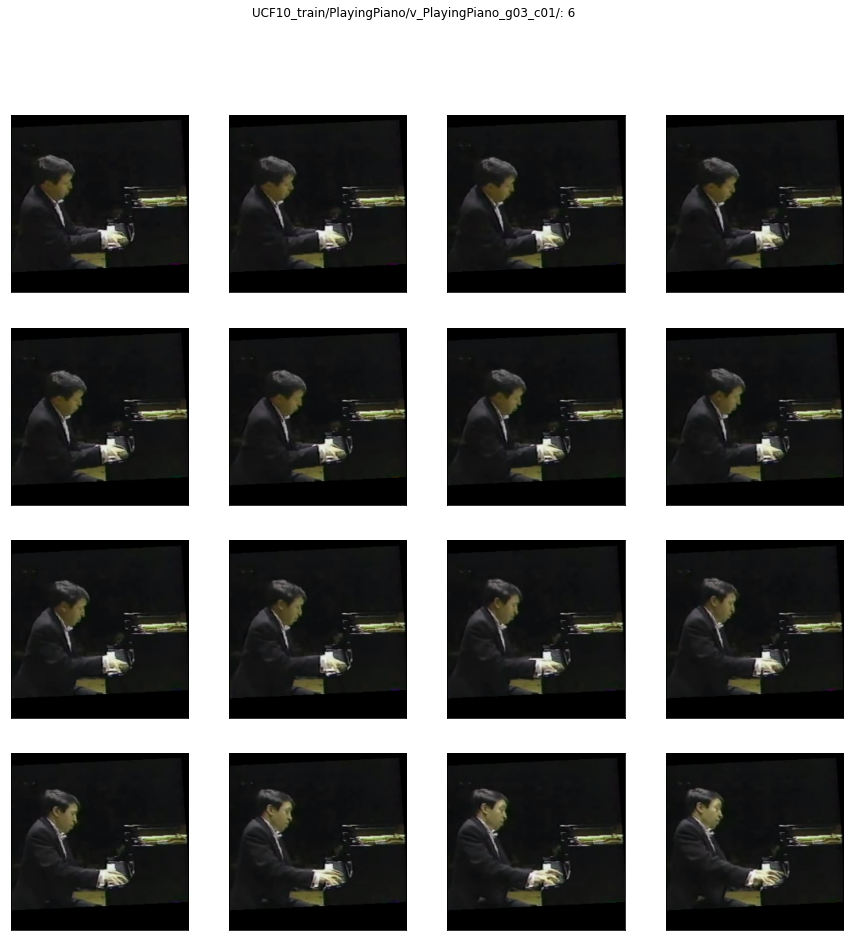

In [22]:
example = ucf_train_dataset.__getitem__(int(len(ucf_train_dataset)*.64))

frames = example['frames']
path = example['path']
label = example['label']

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle(f'{path}: {label}')
for i in range(frames.shape[0]):
    frame_img = transforms.ToPILImage()(frames[i])
    axs[i//4, i%4].imshow(np.asarray(frame_img))
    axs[i//4, i%4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()

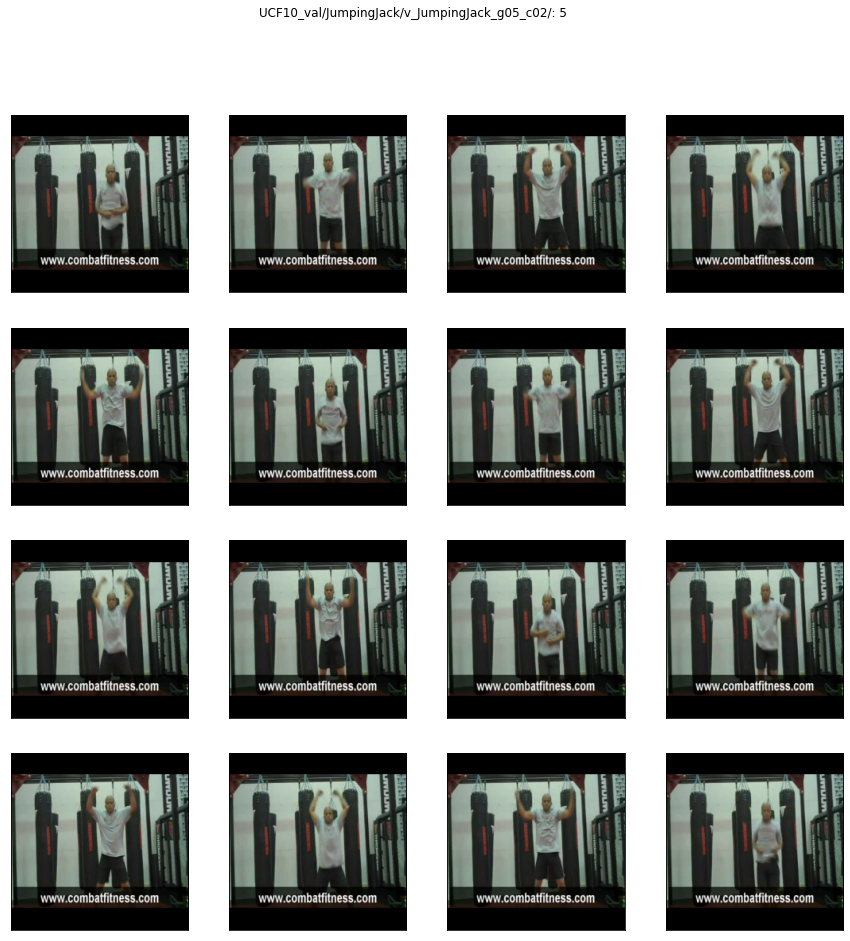

In [23]:
example = ucf_val_dataset.__getitem__(int(len(ucf_val_dataset)*.56))

frames = example['frames']
path = example['path']
label = example['label']

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle(f'{path}: {label}')
for i in range(frames.shape[0]):
    frame_img = transforms.ToPILImage()(frames[i])
    axs[i//4, i%4].imshow(np.asarray(frame_img))
    axs[i//4, i%4].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()

## Set up model.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# Ref.: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(100.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [13]:
class VideoClf(torch.nn.Module):
    
    def __init__(self, n_frames=16, n_classes=10):
        super(VideoClf, self).__init__()
        self.cnn = efficientnet_b3(pretrained=True)
        self.cnn.classifier[1] = torch.nn.Identity()
        self.cnn.requires_grad_(False)
        self.transformer_d_model = 1536 #Second last layer size of the EfficientNet-B3 CNN.
        self.base_model = torch.nn.Sequential(self.cnn,\
                                              torch.nn.Dropout(p=0.))
        self.n_frames = n_frames
        self.n_classes = n_classes
        self.pos_encoder = PositionalEncoding(d_model=self.transformer_d_model, dropout=0.)
        self.encoder_layer = TransformerEncoderLayer(d_model=self.transformer_d_model, nhead=8, batch_first=True, dropout=0.1)
        self.encoder = TransformerEncoder(self.encoder_layer, num_layers=12)
        self.relu1 = torch.nn.ReLU()
        self.linear1 = Linear(self.transformer_d_model, 512)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(p=0.)
        self.linear2 = Linear(512, self.n_classes)
    
    def forward(self, x):
        x = torch.stack([self.base_model(x[i]) for i in range(x.shape[0])], dim=0)
        x = torch.reshape(x, (-1, self.n_frames, self.transformer_d_model))
        x = self.pos_encoder(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.linear2(self.dropout2(self.relu2(self.linear1(self.relu1(x)))))
        return x

In [14]:
model = VideoClf()
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = MultiStepLR(optimizer, milestones=[100], gamma=0.5)

## Set up one-epoch training activity.

In [14]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    total_correct = 0
    total_num = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(ucf_train_dataloader):
        # Every data instance is an input + label pair
        inputs = data['frames']
        labels = data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item() * len(labels)
        total_num += len(labels)
        total_correct += len(labels[torch.argmax(outputs, dim=1)==labels])

    checkpoint = {}
    checkpoint['epoch'] = epoch_index
    checkpoint['model_state_dict'] = model.state_dict()
    checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(checkpoint, 'latest_checkpoint.pth')

    return running_loss / total_num, total_correct / total_num

## Train the model. (Output shown is from one of the experiment runs during parameter tuning.)

In [15]:
# Initializing in a separate cell so we can easily add more epochs to the same run
writer = SummaryWriter('fashion_trainer')
epoch_number = 0

EPOCHS = 2000

best_vloss = 1_000_000.

for epoch in range(epoch_number, EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss, train_acc = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.eval()
    
    running_vloss = 0.0
    total_num = 0
    total_correct = 0
    for i, vdata in enumerate(ucf_val_dataloader):
        vinputs = vdata['frames']
        vlabels = vdata['label']
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        with torch.no_grad():
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss * len(vlabels)
        total_num += len(vlabels)
        total_correct += len(vlabels[torch.argmax(voutputs, dim=1)==vlabels])
        
    avg_vloss = running_vloss / total_num
    val_acc = total_correct / total_num
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACC train {} valid {}'.format(train_acc, val_acc))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'best_model.pth'
        torch.save(model.state_dict(), model_path)
    torch.save(model.state_dict(), 'latest_model.pth')
    
#     scheduler.step()

    epoch_number += 1
    

EPOCH 1:
LOSS train 5.339179548931423 valid 3.056866407394409
ACC train 0.10830704521556257 valid 0.0966183574879227
EPOCH 2:
LOSS train 2.6449520896285867 valid 2.4945266246795654
ACC train 0.11777076761303891 valid 0.0966183574879227
EPOCH 3:
LOSS train 2.4217269182455903 valid 2.3809823989868164
ACC train 0.11356466876971609 valid 0.14492753623188406
EPOCH 4:
LOSS train 2.3746679854568495 valid 2.345392942428589
ACC train 0.10830704521556257 valid 0.10144927536231885
EPOCH 5:
LOSS train 2.3879440076468996 valid 2.386972427368164
ACC train 0.12197686645636173 valid 0.10144927536231885
EPOCH 6:
LOSS train 2.3965569876220574 valid 2.391751527786255
ACC train 0.09779179810725552 valid 0.09178743961352658
EPOCH 7:
LOSS train 2.425901084292198 valid 2.3863866329193115
ACC train 0.08412197686645637 valid 0.09178743961352658
EPOCH 8:
LOSS train 2.3805449883895218 valid 2.370116710662842
ACC train 0.10199789695057834 valid 0.14492753623188406
EPOCH 9:
LOSS train 2.371644635055093 valid 2.357

KeyboardInterrupt: 

## Inference over validation set using best model from the best experiment run. Plot the confusion matrix.

In [15]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [16]:
model.eval()

VideoClf(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation

In [17]:
running_vloss = 0.0
total_num = 0
total_correct = 0
all_vlabels = []
all_vpreds = []
for i, vdata in enumerate(ucf_val_dataloader):
    vinputs = vdata['frames']
    vlabels = vdata['label']
    all_vlabels += vlabels.tolist()
    vinputs = vinputs.to(device)
    vlabels = vlabels.to(device)
    with torch.no_grad():
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    all_vpreds += torch.argmax(voutputs, dim=1).tolist()
    running_vloss += vloss * len(vlabels)
    total_num += len(vlabels)
    total_correct += len(vlabels[torch.argmax(voutputs, dim=1)==vlabels])

avg_vloss = running_vloss / total_num
val_acc = total_correct / total_num

In [18]:
avg_vloss = running_vloss / total_num
val_acc = total_correct / total_num
print('LOSS valid {}'.format(avg_vloss))
print('ACC valid {}'.format(val_acc))

LOSS valid 0.5941487550735474
ACC valid 0.8357487922705314


In [19]:
conf_mat = confusion_matrix(all_vlabels, all_vpreds)

In [20]:
keys = [key.split('/')[1] for key in ucf_val_dataset.labels.keys()]

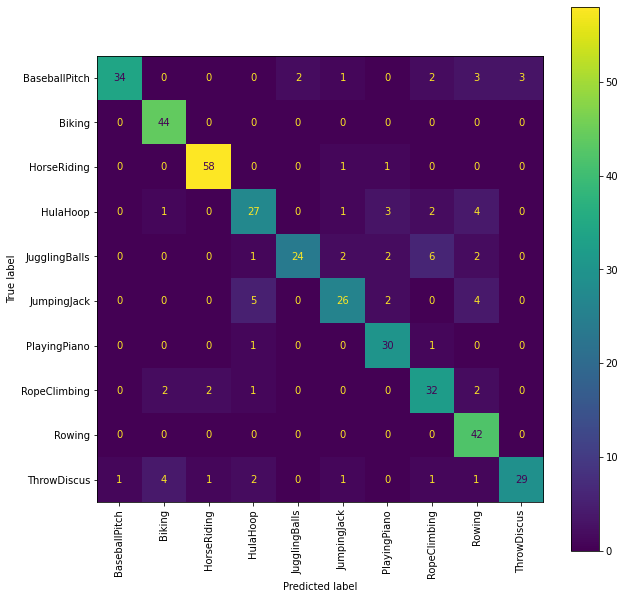

In [21]:
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=keys)
_, ax = plt.subplots(figsize=(10,10))
cmd.plot(xticks_rotation='vertical', ax=ax)